# MSDS 7331 - Case Study 1 - Superconducting Materials
Daniel Crouthamel,
Sophia Wu,
Fabio Savorgnan,
Bo Yun


## Introduction
In this study, we will build a linear regression model using L1 or L2 regularization to predict the critical temperature. There are total 6 sections in this case analysis:

1. Business Understanding
2. Data Evaluation / Engineering
3. Modeling Preparations
4. Model Building & Evaluation
5. Model Interpretability & Explainability
6. Case Conclusions

In [1]:
#importing libraries and reading in file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#general sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

#logistic regression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline



## Business Understanding

**Objective:** 
The objective of this case study is to explore Linerar Regression with L1 and L2 regularization, and the impact to predicting the critical temperature of a superconductor. Additionally, feature importance is also investigated with the best model. Three models will be considered.

* Lasso (L1)
* Ridge (L2)
* Elastic Net (L1 and L2).

Grid search will be performed on each model to find the optimal hyperparameters. We'll then use the optimal hyperparameters for each model and then determine which model performs the best. Along the way will explore the importance of normalization and scaling and condlude with a summary of the most important features.

## Data Evaluation and Engineering


Below we'll load our supoerconductor data and then perform a quick data exploration. Our data consists of two files which were merged together. Some initial obervations are:

* There is no missing data
* We have features with constant values
* There is one string object in the dataframe

In [2]:
# Load Data
data_train = pd.read_csv('data/train.csv')
data_materials = pd.read_csv('data/unique_m.csv')


#### Addressing missing Values

In [3]:

# Drop the duplicate column 'critical_temp' in the first frame
data_train = data_train.drop(['critical_temp'], axis=1)

# Merge the two frames
data = pd.merge(data_train, data_materials, left_index=True, right_index=True)

# Data frame to csv drop index
#data.to_csv('data/super_conducter_data.csv', index=False)

# Print out some typicaly descriptive statistics
print("")
data.info()
data.describe()

# Do we have missing data?
print("")
print("Missing Data?", data.columns[data.isnull().any().values])

# Columns with a Constant value
print("")
print("Columns that have the same value", data.columns[data.nunique() <= 1].values)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Columns: 169 entries, number_of_elements to material
dtypes: float64(156), int64(12), object(1)
memory usage: 27.4+ MB

Missing Data? Index([], dtype='object')

Columns that have the same value ['He' 'Ne' 'Ar' 'Kr' 'Xe' 'Pm' 'Po' 'At' 'Rn']


### Data Cleaning - Duplicates
Now we will work on cleaning up any duplicates in our dataset.The string feature will be removed from our data set. This appears to be a name, and some values are duplicated. We felt it was safe to remove. Addtionally, the features identified above with constant values will be removed.
After doing a quick profiling on all of 159 columns, we don't see any missing data.

In [4]:
# Drop columns with constant values
data.drop(columns=['material', 'He', 'Ne', 'Ar', 'Kr', 'Xe', 'Pm', 'Po', 'At', 'Rn'], inplace=True)
print(data.shape)

(21263, 159)


### Simple Statistics
We will next review some simple statistics on our dataset.This will be primarily focused on our main expected variable of 'temperature'. First, we'll check the range, mode, mean, median, variance and counts for the variable of 'temperature'. Then we'll check the relationships between temperature and other attributes.
#### Median, Standard Deviation, Mean of  'critical temperature'
We can see from observing the simple statistic is that the median critical temperature is around 20. However, what's interesting to note here is that the median and the mean are very different with the big gap of 14.42. There is a standard deviation of about 34.254. 

In [5]:
print(data['critical_temp'].aggregate([np.median, np.std, np.mean]).reset_index())
print('min: '+str(data['critical_temp'].min()))
print('min: '+str(data['critical_temp'].max()))

    index  critical_temp
0  median      20.000000
1     std      34.254362
2    mean      34.421219
min: 0.00021
min: 185.0


#### Distribution of critical temperature
As our main focus variable is critical temperature, we will look deeper into this variable. From a simple IQR districution, we can see the majority of the data is between 5 and 63.

In [6]:
print(data.describe()['critical_temp'][['25%', '50%', '75%']])
print(data.max()['critical_temp'])

25%     5.365
50%    20.000
75%    63.000
Name: critical_temp, dtype: float64
185.0


Then we want to visualize the distribution for our primary variable critical temperature with a boxplot and histogram.

C:\Users\dancr\miniconda3\envs\NLP\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


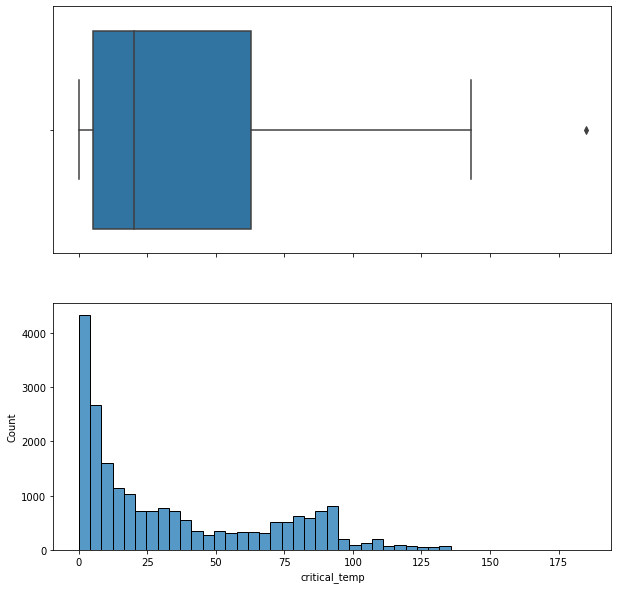

In [7]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(10,10))
 
sns.boxplot(data["critical_temp"], x="critical_temp", ax=ax_box)
sns.histplot(data, x="critical_temp", ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

Above there seems to be one strange outlier to the right at around 180. Since we are not domain experts here, we are going to keep it in our data set. 

We took a look the simple statistics of the continuous variables to see if they make sense and has reasonable data distribution. Outliers could be extreme minimum and maximum that resulted from data entry error or the nature of the nature itself.  

*  The 25% and 75% interquartile range (IQR) was utilized in order to identify and remove the outliers from the dataset.
*  Outliers that are positioned at above and below the 1.5 times the upper and lower limit of IQR are removed
*  gmean_atomic_mass is the variable with the most reduction (Down to 17949 from 21263 entries, 15% reduction)
*  Other variables also have shown significant reduction after outlier removal. Thus outlier removal is not recommended.
*  Additionally, we do not have domain expertise on this dataset to determine the requirement of what it takes to be outliers. Thus we assume that there is no outliers for this study.

Perhaps this what the scientists want. A room temperature superconductor!

The code below is used to create a pandas profile, which is an easy way to see summary statistics for each feature. The html file will be provided as part of the case study submission. Some findings from that report are:

* Confirms no missing values
* There are no negative values
* Varying distrubutions for the features, some bell shaped, others poisson, etc.
* We have features with skewness and outliers.

To run the code, uncomment the last 3 lines of code below and run the cell. The first two lines indicate what needs to be installed. You will need to use an older version of pandas. After dropping the duplicates from our dataset, we still have 159 columns. For now, we assume the temperature is significant correlated with all of other 158 variables.

In [8]:
## install pandas 1.2.4
## pip install pandas-profiling==2.8.0

# from pandas_profiling import ProfileReport
# profile = ProfileReport(data, title="Pandas Profiling Report", minimal=True)
# profile.to_file(output_file="PandasProfile.html")

## Modeling Preparations

### Methods
In a dataset that has a large number of features, there is a strong tendency for a linear regression model to overfit. We will be using three different models: Lasso(L1), Ridge(L2) and Elastic Net to overcome the issue of overfitting and to optimize this linear regression problem. We will also apply GridSearch to tune the hyper-parameters for these models. The followings are brief descriptions of how each algorithm works and how they apply to this problem. 

__`LASSO(L1)`__
* It reduces some coefficients to absolute zero while it keeps some in the model. This property is known as feature selection and is absent in RIDGE. 
* This algorithm is useful in models with a large number of features like this case study(159 features) 
* In case of multicollinearity, LASSO will randomly pick one of its correlated variables and set the rest to zero. This can lead to some loss of important information and result in lower accuracy. Thus we will proceed with caution. 

__`RIDGE(L2)`__
* It shrinks the coefficients, therefore it reduces model complexity and multicollinearity. 
* Even after the magnitude of the coefficients are reduced, it still retains all the features, which may lead to poor performance.  

__`Elastic Net`__
* Combination of LASSO and RIDGE and uses both L1 and L2 penalty terms. 
* Generally works well with large dataset. 


### Evaluation Metrics
- For each model we'll use __R²__ as a cross validation metric, which can explain the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable. However, R² alone cannot be used for comparing the models as the value of R² increases with the increase in the number of predictors. This is important to note since we will have different number of predictors in our models due to LASSO performing feature reduction by shrinking coefficients to absolute zero. 
- We'll then incorporate __MAE__ (Mean Absolute Error), which is simply the average of the absolute difference between predicted and test values, to compare Lasso, Ridge, or Elastic Net. 
- In conclusion, we will select the best performing model based on combinations of __largest R² value and smallest MAE__. We will also look into the top coefficients that contribute the most to the chosen model and utilize them to interpret the model. 


## Model Building and Evaluation

Below we create three models for Lasso, Ridge and Elastic Net. We'll creaete a pipeline for each model that will scale the data using RobustScaler and then use Grid Search with cross validation. Our data is split in 80% training and 20% test sets. We'll then use the test sets to evaluate each of the models at the end.

Note that we'll be using the Pipeline approach in SKlearn. This allows us to define a sequence of steps to be performed on the data. First, we'll scale the data using RobustScaler. Because of the skewness and outliers of some features, we decided to use the RobustScaler which scales features using statistics that are robust to outliers. Next we'll define the model to be used (Lasso vs Ridge vs ElasticNet). Finally, we'll use Grid Search to find the optimal hyperparameters. By using a Pipeline with GridSearchCV we only scale the data in the training set. The test sets in each fold are then scaled using the same scaler. We are trying to eliminate data leakage. Please see references below for more information.

For Lasso and Ridge, we'll vary the hyperparameter alpha. For Elastic Net, we'll vary the hyperparameters alpha, which is a constant that multiplies the penalty terms. Additionally, we'll vary the hyperparameter l1_ratio which controls the amount of mixing between L1 and L2. If l1_ratio is 1, then we'll only use L1 regularization. If l1_ratio is 0, then we'll only use L2 regularization.

**Hyperparameters Used**
param_range = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100, 1000, 10000]
param_l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

https://towardsdatascience.com/pre-process-data-with-pipeline-to-prevent-data-leakage-during-cross-validation-e3442cca7fdc  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html  
https://scikit-learn.org/stable/modules/cross_validation.html  
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html  
https://stats.stackexchange.com/questions/445259/combining-pca-feature-scaling-and-cross-validation-without-training-test-data  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html?highlight=elasticnet#sklearn.linear_model.ElasticNet  
https://machinelearningmastery.com/data-preparation-without-data-leakage/  
https://stackoverflow.com/questions/35388647/how-to-use-gridsearchcv-output-for-a-scikit-prediction  


In [9]:

X = data.drop(columns=['critical_temp']).copy(deep=True)
y = data.loc[:,'critical_temp'].copy(deep=True)

X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
    test_size=0.2,
    random_state=1)

lasso_pipe_svc = make_pipeline(RobustScaler(), Lasso(random_state=1))
ridge_pipe_svc = make_pipeline(RobustScaler(), Ridge(random_state=1))
elastic_pipe_svc = make_pipeline(RobustScaler(), ElasticNet(random_state=1))

param_range = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100, 1000, 10000]
param_l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

param_grid_lasso = [{'lasso__alpha': param_range}]
param_grid_ridge = [{'ridge__alpha': param_range}]
param_grid_elastic = [{'elasticnet__alpha': param_range, 'elasticnet__l1_ratio': param_l1_ratio}]

gs_lasso = GridSearchCV(estimator=lasso_pipe_svc, param_grid=param_grid_lasso, scoring='r2', cv=5, n_jobs=-1)
gs_lasso.fit(X_train, y_train)

gs_ridge = GridSearchCV(estimator=ridge_pipe_svc, param_grid=param_grid_ridge, scoring='r2', cv=5, n_jobs=-1)
gs_ridge.fit(X_train, y_train)

gs_elastic = GridSearchCV(estimator=elastic_pipe_svc, param_grid=param_grid_elastic, scoring='r2', cv=5, n_jobs=-1)
gs_elastic.fit(X_train, y_train)

print("Lasso")
print(gs_lasso.best_score_)
print(gs_lasso.best_params_)
print("")

print("Ridge")
print(gs_ridge.best_score_)
print(gs_ridge.best_params_)
print("")

print("Elastic")
print(gs_elastic.best_score_)
print(gs_elastic.best_params_)
print("")

Lasso
0.7129520975572087
{'lasso__alpha': 0.3}

Ridge
0.706531275524331
{'ridge__alpha': 1000}

Elastic
0.7083853891920866
{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 0.9}



Above we see that each model performs almost identically on the training data. Recall that L1 is used for Lasso, and L2 is used for Ridget. Elastic Net uses both. The optimal l1_ration hyperparameter found for ElasticNet is 0.9. It's moving into the direction of Lasso. If the ratio is 1, it's Lasso, if it's 0, it's Ridge.

Additionally, the optimal alpha found for Ridge is 1000, which is quite high. It's trying to penalize cofficients harder, which means we'll see more coefficients that are close to zero.

Next we'll perform predictions on our test data. Note that because we are using a pipeline, the scaler is only applied to the test data. This ensures that we have no leakage of information from the training data.
https://stackoverflow.com/questions/35388647/how-to-use-gridsearchcv-output-for-a-scikit-prediction

In [10]:
from sklearn import metrics

# Note the X_test gets run through the pipeline above! Very important, it means that the scaler is also run on the test data
y_lasso_pred = gs_lasso.predict(X_test)
y_ridge_pred = gs_ridge.predict(X_test)
y_elastic_pred = gs_elastic.predict(X_test)

print("Lasso")
print("R2 ->", metrics.r2_score(y_test, y_lasso_pred))
print("MAE ->", metrics.mean_absolute_error(y_test, y_lasso_pred))

print("Ridge")
print("R2 ->", metrics.r2_score(y_test, y_ridge_pred))
print("MAE ->", metrics.mean_absolute_error(y_test, y_ridge_pred))
print("")

print("Elastic")
print("R2 ->", metrics.r2_score(y_test, y_elastic_pred))
print("MAE ->", metrics.mean_absolute_error(y_test, y_elasti
c_pred))
print("")

Lasso
R2 -> 0.7197254814065868
MAE -> 13.660714491348584
Ridge
R2 -> 0.7264906957630273
MAE -> 13.359929361601823

Elastic
R2 -> 0.7146988481193569
MAE -> 13.811785860925973



Above we see that the R2 values are consistent with what we found on the training data. However, the Ridge model performans marginally better. In this case I'd be inclined to use the Lasso model because of the reduced number of features. Below we output the ABSOLUTE value of each coefficient, in sorted fashion. This helps to give an indication of which features are important. The sign doesn't matter.

In [11]:
lasso_weights = {data.columns[k]:abs(v) for k, v in enumerate(gs_lasso.best_estimator_['lasso'].coef_)}
dict(sorted(lasso_weights.items(), key=lambda item: item[1], reverse=True))

{'Ba': 12.747910288530562,
 'wtd_gmean_ThermalConductivity': 12.364521222651708,
 'wtd_mean_ThermalConductivity': 11.947603500510482,
 'range_atomic_mass': 6.955103730407498,
 'wtd_std_Valence': 6.5603440594602995,
 'wtd_gmean_ElectronAffinity': 4.328328539587897,
 'Bi': 3.97490881456744,
 'wtd_entropy_atomic_mass': 3.9508095199980304,
 'wtd_entropy_ThermalConductivity': 3.924730652055882,
 'Ca': 3.3178161344471087,
 'wtd_entropy_FusionHeat': 2.8062532004771885,
 'wtd_entropy_ElectronAffinity': 2.5435733987843343,
 'mean_Density': 1.7386569847400537,
 'Si': 1.6972961033719114,
 'mean_fie': 1.5836528543493764,
 'Sr': 1.3418330269172292,
 'wtd_range_atomic_mass': 1.2028148462719683,
 'range_atomic_radius': 1.1880683928528302,
 'As': 1.1522532857677543,
 'S': 1.0526391079045863,
 'wtd_std_FusionHeat': 1.046997414247526,
 'mean_ThermalConductivity': 0.9839999275894176,
 'wtd_std_atomic_mass': 0.7363630703449164,
 'wtd_range_FusionHeat': 0.5820119169251454,
 'wtd_range_Density': 0.557855764

In [12]:
ridge_weights = {data.columns[k]:abs(v) for k, v in enumerate(gs_ridge.best_estimator_['ridge'].coef_)}
dict(sorted(ridge_weights.items(), key=lambda item: item[1], reverse=True))

{'Ba': 10.370112488683707,
 'wtd_mean_ThermalConductivity': 6.483779782189918,
 'wtd_std_Valence': 6.0513734789108,
 'wtd_gmean_ThermalConductivity': 5.803254805998128,
 'range_atomic_mass': 4.462011897968567,
 'Bi': 4.206544355861212,
 'wtd_std_ThermalConductivity': 3.828515214405895,
 'wtd_gmean_ElectronAffinity': 3.5891168955214394,
 'Ca': 3.410551989821315,
 'wtd_entropy_ElectronAffinity': 3.394887646825798,
 'wtd_std_atomic_mass': 3.196081179425659,
 'wtd_entropy_atomic_mass': 2.8317915478141638,
 'mean_ThermalConductivity': 2.7609890505040484,
 'wtd_entropy_FusionHeat': 2.5880223369523963,
 'gmean_ThermalConductivity': 2.5244734431093048,
 'range_atomic_radius': 2.52409341126252,
 'Hg': 2.5220927025032776,
 'wtd_range_ElectronAffinity': 2.521911168615366,
 'std_ElectronAffinity': 2.4642131470561,
 'Tl': 2.454638635844284,
 'Ag': 2.3027845073780266,
 'std_atomic_mass': 2.274435755236311,
 'wtd_mean_atomic_radius': 2.2379734200628874,
 'wtd_std_atomic_radius': 2.225423834408331,
 '

## Model Interpretability & Explainability


In [13]:
data
col= data[['Ba','wtd_gmean_ThermalConductivity','wtd_mean_ThermalConductivity' ]]
col

,Ba,wtd_gmean_ThermalConductivity,wtd_mean_ThermalConductivity
0,0.20,0.621979,61.015189
1,0.10,0.619735,61.372331
2,0.10,0.619095,60.943760
3,0.15,0.620535,60.979474
4,0.30,0.624878,61.086617
...,...,...,...
21258,0.00,95.001493,111.537778
21259,2.00,1.577047,108.680590
21260,0.00,57.038314,57.400000
21261,0.00,58.781651,59.270000


In [14]:
#calculate interquartile range for Ba
q3, q1 = np.percentile(data['Ba'], [75 ,25])
iqr_BA = q3 - q1
#display interquartile range 
iqr_BA

1.35

In [15]:
#calculate interquartile range for Ba
q3, q1 = np.percentile(data['wtd_gmean_ThermalConductivity'], [75 ,25])
iqr_Ther_gmean = q3 - q1
#display interquartile range 
iqr_Ther_gmean

46.22075786432602

In [16]:
#calculate interquartile range for Ba
q3, q1 = np.percentile(data['wtd_mean_ThermalConductivity'], [75 ,25])
iqr_Ther_mean = q3 - q1
#display interquartile range 
iqr_Ther_mean

44.881957804581404

We decided to use the Lasso model because the performance as explained above, and the reduction of colinearity. The most important variable in the lasso model were the following:

'Ba': 12.747910288530564,

'wtd_gmean_ThermalConductivity': 12.364521222651712,

'wtd_mean_ThermalConductivity': 11.947603500510484

As you can see these 3 variables are the only variables among the 159 variables choosen to run the model that have a weight above 10. Therefore, the 3 mentioned variables are the most important variable to predict critical temperature by the lasso model.

Because we had the necessity to normalize our data due to different distribution of the values in the variables. In order to provide appropriate variables to compare in the model, we interpret the variables accounting for our normalized data. We used the robust scalar for normalization. This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).
Therefore, the interpretation of the most important 3 variables mentioned above are the following:
BA= for any increase in 1.35 of the BA variables we will have an increase in the critical temperature of 12.75, when we keep constant the othe variables.
Wtd_gmean_ThermalConductivity= for any increase in 46.22 of the wtd_gmean_ThermalConductivity variable we will have an increase in the critical temperature of 12.36, when we keep constant the othe variables.
Wtd_mean_ThermalConductivity= for any increase in 44.89 of the wtd_mean_ThermalConductivity variable we will have an increase in the critical temperature of 11.95, when we keep constant the othe variables.

The lasso model has MAE= 13.6; the general interpretation of this model for the user is that any prediction with this model will have a mean error of plus/minus 13.6.


## Case Conclusions

We will recommend to our audience to keep in mind that the most important variables to relate to critical high temperature are Ba,  wtd_gmean_ThermalConductivity, wtd_mean_ThermalConductivity. Because those variables turned out to have the highest weight in the lasso regularization model. So, moving forward the audience should concentrate in these 3 variables in the control or manipulation of critical high temperature. Furthermore, it is very reassurance that the same variables came out in the other models that we run as the variables with higher weight of importance. For the future, it can be done a prospective study looking the relation with of these 3 variables and critical high temperature. 